## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
solvency_statistics = pd.read_csv('/datasets/data.csv')
from IPython.display import display
from pymystem3 import Mystem
m = Mystem()
import matplotlib.pyplot as plt

display(solvency_statistics)
solvency_statistics.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [2]:
print(solvency_statistics['education'].unique())

['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']


### Вывод

После открытия файла я обнаруживаю:

1. пропуски в двух столбцах: **days_employed** и **total_income**
2. повторения в столбце **purpose**
3. отрицательные значения в столбце **days_employed**
4. дубликаты из-за регистра в стобце **education**
5. тип данных столбца **days_employed** необходимо заменить на целочисленный
6. тип данных столбца **total_income** также хочется изменить на int, но ранее в курсе было неплохо сказано, что это не просто цифры, а деньги пользователей, в конкретном случае, банка, так что я ещё подумаю над необходимостью округлять.

### Шаг 2. Предобработка данных

### Обработка пропусков

In [3]:
solvency_statistics_filter = solvency_statistics[solvency_statistics['days_employed'].isna()] # создаю новую таблицу 
# c отфильтрованными значениями
# по столбцу 'days_employed'
solvency_statistics_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


In [4]:
print(solvency_statistics_filter['children'].value_counts() / solvency_statistics['children'].value_counts() * 100)
# % не вернувших кредит в срок для категорий столбца children

-1      6.382979
 0     10.170330
 1      9.858863
 2      9.927007
 3     10.909091
 4     17.073171
 5     11.111111
 20    11.842105
Name: children, dtype: float64


In [5]:
solvency_statistics.groupby('children')['debt'].mean().reset_index()

,children,debt
0,-1,0.021277
1,0,0.075129
2,1,0.092154
3,2,0.094404
4,3,0.081818
5,4,0.097561
6,5,0.000000
7,20,0.105263


In [6]:
display(solvency_statistics_filter.groupby('children')['debt'].count() / 
solvency_statistics.groupby('children')['debt'].count() * 100)

children
-1      6.382979
 0     10.170330
 1      9.858863
 2      9.927007
 3     10.909091
 4     17.073171
 5     11.111111
 20    11.842105
Name: debt, dtype: float64

In [7]:
print(solvency_statistics_filter['family_status'].value_counts() / solvency_statistics['family_status'].value_counts() * 100)

женат / замужем           9.991922
гражданский брак         10.581757
Не женат / не замужем    10.238180
в разводе                 9.372385
вдовец / вдова            9.895833
Name: family_status, dtype: float64


In [8]:
display(solvency_statistics_filter.groupby('family_status')['debt'].count() / 
solvency_statistics.groupby('family_status')['debt'].count() * 100)
# тоже самое, что и чуть выше, но другим способом

family_status
Не женат / не замужем    10.238180
в разводе                 9.372385
вдовец / вдова            9.895833
гражданский брак         10.581757
женат / замужем           9.991922
Name: debt, dtype: float64

In [9]:
solvency_statistics_filtered = solvency_statistics.dropna().reset_index(drop=True) # создаю таблицу, очищенную от пропусков.
solvency_statistics_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 12 columns):
children            19351 non-null int64
days_employed       19351 non-null float64
dob_years           19351 non-null int64
education           19351 non-null object
education_id        19351 non-null int64
family_status       19351 non-null object
family_status_id    19351 non-null int64
gender              19351 non-null object
income_type         19351 non-null object
debt                19351 non-null int64
total_income        19351 non-null float64
purpose             19351 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 1.8+ MB


### Вывод

Я обнаружил пропуски в количественных переменных, нашел взаимосвязь, что пропуски в столбцах 'days_employed' и 'total_income' находятся в одних и тех же строках. Также сравнил данные, интересующих меня по заданию столбцов, в таблицах: solvency_statistics и solvency_statistics_filter и увидел, что данные в таблице solvency_statistics_filter составляют приблизительно 10% от данных solvency_statistics. Соответственно, если удалить все строки, содержащие NaN в каком-либо столбце, то общая картина происходящего не изменится. Есть конечно в данных выброс в виде 17% не вернувших деньги в срок в категории семьи с 4 детьми, но это можно рассматривать, как выброс, вызванный малым количеством данных.

Я постарался найти взаимосвязь появления пропусков в зависимости от пола, кол-ва детей или образования, семейного положения, но никакой взаимосвязи выявить не удалось, соответственно, это не позволяет мне свалить всю вину на многодетную мать без образования, и я могу предположить, что пропуски вызваны системной ошибкой, так как при отправлении заявки на кредит все поля являются обязательными для заполнения, что исключает возможность, что кто-то хотел заполнить, а кому-то было лень.

### Замена типа данных

In [10]:
solvency_statistics_filtered[['days_employed', 'total_income']] = solvency_statistics_filtered[['days_employed', 'total_income']].astype('int')
# меняю тип данных на int
# solvency_statistics_filtered['total_income'] = solvency_statistics_filtered['total_income'].astype('int')
# меняю тип данных на int
solvency_statistics_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 12 columns):
children            19351 non-null int64
days_employed       19351 non-null int64
dob_years           19351 non-null int64
education           19351 non-null object
education_id        19351 non-null int64
family_status       19351 non-null object
family_status_id    19351 non-null int64
gender              19351 non-null object
income_type         19351 non-null object
debt                19351 non-null int64
total_income        19351 non-null int64
purpose             19351 non-null object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB


### Вывод

Поскольку данные в столбце days_employed уже имели тип float, то мне нужно было лишь воспользоваться методом astype для перевода в int.

Для удобства дальнейшего использования и из-за отсутствия нужды в подсчёте копеек округляю и данные с зарплатами.

### Обработка дубликатов

In [11]:
print(solvency_statistics_filtered['education'].value_counts())

среднее                12342
высшее                  4222
СРЕДНЕЕ                  705
Среднее                  646
неоконченное высшее      613
ВЫСШЕЕ                   251
Высшее                   243
начальное                231
Неоконченное высшее       40
НЕОКОНЧЕННОЕ ВЫСШЕЕ       22
НАЧАЛЬНОЕ                 16
Начальное                 14
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64


In [12]:
solvency_statistics_filtered['education'] = solvency_statistics_filtered['education'].str.lower() # приведение к нижнему регистру
print(solvency_statistics_filtered['education'].value_counts())

среднее                13693
высшее                  4716
неоконченное высшее      675
начальное                261
ученая степень             6
Name: education, dtype: int64


### Вывод

Метод str.lower() был использован по причине наличия разного регистра, чем и было вызвано дублирование.

1. Причина дублирования в том, что у пользователя нет возможности просто выбрать тип образования, а необходимо его вводить вручную.
2. Причина, что отсутствует подсказка каким регистром требуется заполнить поле.
3. Нет проверки на регистр, которая выдавала бы ошибку пользователю.
4. Ну а если есть поле с подсказкой, то, очевидно, тут уже ошибка самого пользователя.

### Лемматизация

In [13]:
def solvency_statistics_purpose(purpose):
    """
    создаю функцию, которая лемматизирует
    входные данные и записывает их
    в переменную lemmas
    """
    lemmas = m.lemmatize(purpose)
    return lemmas

solvency_statistics_filtered['purpose_lemm'] = solvency_statistics_filtered['purpose'].apply(solvency_statistics_purpose)
# добавляю в датафрейм новый столбец с лемматизированными данными
print(solvency_statistics_filtered['purpose_lemm'].value_counts())

[автомобиль, \n]                                          875
[свадьба, \n]                                             721
[сыграть,  , свадьба, \n]                                 693
[на,  , проведение,  , свадьба, \n]                       685
[операция,  , с,  , недвижимость, \n]                     615
[покупка,  , коммерческий,  , недвижимость, \n]           597
[покупка,  , жилье, \n]                                   595
[покупка,  , жилье,  , для,  , сдача, \n]                 588
[жилье, \n]                                               587
[операция,  , с,  , коммерческий,  , недвижимость, \n]    581
[строительство,  , жилой,  , недвижимость, \n]            580
[операция,  , с,  , жилье, \n]                            579
[покупка,  , свой,  , жилье, \n]                          574
[недвижимость, \n]                                        572
[покупка,  , жилье,  , для,  , семья, \n]                 570
[строительство,  , недвижимость, \n]                      561
[строите

### Вывод

Я сделал лемматизацию с помощью библиотеки pymystem3, создал функцию, с помощью которой лемматизировал весь столбец и записал все лемматизированные данные в новый столбец.

### Категоризация данных

In [14]:
def purpose_credit(purpose_lemm):
    """
    я выбрал 5 категорий
    и с помощью данной функции
    подобрал в каждой строчке столбца "цель кредита"
    свою категорию
    """
    if 'автомобиль' in purpose_lemm:
        return 'операции с автомобилем'
    if 'жилье' in purpose_lemm or ['жилой', 'недвижимость'] in purpose_lemm:
        return 'операции с жильем'
    if 'образование' in purpose_lemm:
        return 'получение образования'
    if 'свадьба' in purpose_lemm:
        return 'свадьба'
    return 'операции с недвижимостью'

solvency_statistics_filtered['purpose_group'] = solvency_statistics_filtered['purpose_lemm'].apply(purpose_credit)
# записал данные после работы функции в новый столбец
solvency_statistics_filtered = solvency_statistics_filtered.drop(['purpose_lemm'], axis=1)
# удалил столбец с леммами, чтобы не было лишних данных в датафрейме
print(solvency_statistics_filtered['purpose_group'].value_counts())

операции с недвижимостью    5723
операции с жильем           4035
операции с автомобилем      3897
получение образования       3597
свадьба                     2099
Name: purpose_group, dtype: int64


### Вывод

Я сгруппировал данные по типу события, теперь в таблице стало проще ориентироваться.

Можно заметить, что 3 лидирующие строчки заняты недвижимостью, жильём и автомобилями, а вот в образование люди вкладываются гораздо реже. А если было бы наоборт? Может, более высокая зп позволила бы удовлетворять потребности без кредитов, да и кредиты на свадьбы может вообще перестали бы брать?

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

children
0      7.490165
1      9.323000
2      9.562399
3      7.482993
4      8.823529
5      0.000000
20    11.940299
Name: debt, dtype: float64


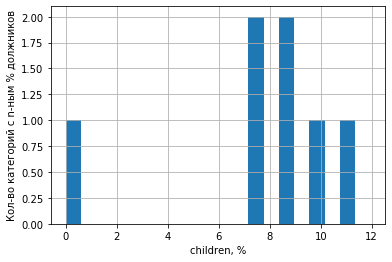

In [15]:
def children_abs(children):
    """
    функция для замены отрицательных
    значений на положительные
    """
    children = abs(children)
    return children

solvency_statistics_filtered['children'] = solvency_statistics_filtered['children'].apply(children_abs)
# перезаписываю столбец данными, полученными на выходе функции  children_abs

def column_mean(name_column):
    """
    функция для рассчета 
    количества должников для
    каждой категории столбцов
    датафрейма
    """
    # print(solvency_statistics_filtered.groupby(name_column)['debt'].sum()) # количество не вернувших кредит в срок
    # print(solvency_statistics_filtered.groupby(name_column)['debt'].count()) # всего взяло кредит
    solvency_statistics_name_column = solvency_statistics_filtered.groupby(name_column)['debt'].mean()*100 # процент должников для каждой из категорий
    print(solvency_statistics_name_column)
    
    width = (solvency_statistics_name_column.max() - solvency_statistics_name_column.min()) / 20 
    # автоподбор ширины линий гистограммы
    plt.xlabel(name_column + ', %')
    plt.ylabel('Кол-во категорий с n-ным % должников')
    solvency_statistics_name_column.hist(width=width) # рисует гистограмму
    
column_mean('children')



<div class="alert alert-info">
Здесь также доработал
</div>

In [16]:
solvency_statistics_filtered.groupby('children')['debt'].mean()

children
0     0.074902
1     0.093230
2     0.095624
3     0.074830
4     0.088235
5     0.000000
20    0.119403
Name: debt, dtype: float64

### Вывод

Определённая взаимосвязь проглядывается - с одной стороны наблюдается, что, чем больше детей, тем меньше шанс, что не выплатят в срок.
С другой стороны это скорее от того, что чем меньше детей в семье, тем чаще берут кредиты, а процент невернувших при любом кол-ве детей всегда одинаков и составляет +-8%. Значения 0% и 12% можно рассматривать как некорректные из-за малого колличества данных.

Таким образом, можно предположить, что большинство стараются разобраться с кредитами до появления первого ребенка.
А дальше, в игру вступает маткапитал и разнообразные льготы для многодетных семей, в т.ч. и квартира от государства и смысла в кредите уже не так много.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

family_status
Не женат / не замужем    10.059406
в разводе                 7.017544
вдовец / вдова            6.473988
гражданский брак          9.076305
женат / замужем           7.592210
Name: debt, dtype: float64


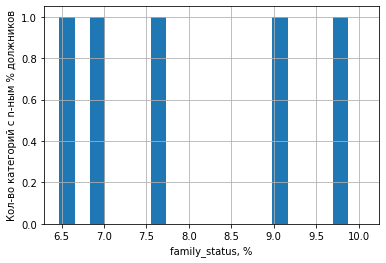

In [17]:
column_mean('family_status')
    


### Вывод

Здесь также нет взаимосвязи между тем, что семейный статус каким то образом влият на выплату в срок, ибо невернувших в каждой категории около 6,5-10% от числа заёмщиков.
Но зато видно, что чаще всего берут кредит уже женатые, видимо, чтобы побыстрее съехать от родителей)
А вот реже всего берут те кто разведены или овдовели, наверно, это каким-то образом связано с психологией людей, возможно начинается депрессия и становится не до кредитов.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

income_rate
2265604              50.000000
1000001 - 1200000     8.333333
100001 - 150000       8.607994
1200001 - 1500000     0.000000
1500000 - 2000000     0.000000
150001 - 200000       8.936377
200001 - 500000       7.101569
30001 - 50000         6.000000
500001 - 700000       5.590062
50001 - 70000         7.078040
700001 - 1000000      8.333333
70001 - 100000        8.464369
< 30000               9.090909
Name: debt, dtype: float64


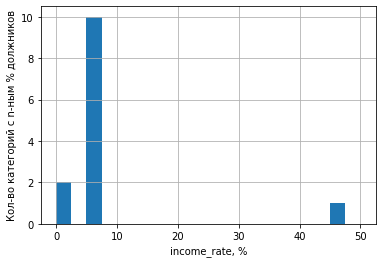

In [18]:
def income(total_income):
    """
    разбиваю весь доход
    не несколько категорий
    """
    if total_income <= 30000:
        return '< 30000'
    if 30001 <= total_income <= 50000:
        return '30001 - 50000'
    if 50001 <= total_income <= 70000:
        return '50001 - 70000'
    if 70001 <= total_income <= 100000:
        return '70001 - 100000'
    if 100001 <= total_income <= 150000:
        return '100001 - 150000'
    if 150001 <= total_income <= 200000:
        return '150001 - 200000'
    if 200001 <= total_income <= 500000:
        return '200001 - 500000'
    if 500001 <= total_income <= 700000:
        return '500001 - 700000'
    if 700001 <= total_income <= 1000000:
        return '700001 - 1000000'
    if 1000001 <= total_income <= 1200000:
        return '1000001 - 1200000'
    if 1200001 <= total_income <= 1500000:
        return '1200001 - 1500000'
    if 1500001 <= total_income <= 2000000:
        return '1500000 - 2000000'
    return 2265604

solvency_statistics_filtered['income_rate'] = solvency_statistics_filtered['total_income'].apply(income)
# добавляю новый столбец в дф с данными, обработанными функцией

column_mean('income_rate')

### Вывод

Взаимосвязи также не обнаружено, и даже в данных по зарплате от 2млн, где из 2-ух занявших лишь 1 вернул в срок, нельзя однозначно утверждать, что таким людям не стоит давать кредиты, просто в данной генеральной выборке слишком мало данных для этой категории, и если бы в каждую категорию попало ровно по 100 наблюдений, то процент невернувших был бы в районе 6-9% для всех категорий, а это говорит мне, что сколько бы человеку не платили, он будет смотреть на что-то недоступное с его зп.

Но видно, что чаще всего прибегают к кредитам те, чей доход от 70тыс до 500тыс. Тут можно предположить, что просто выборка взята по очень крупному городу с высокой средней зп. И в регионах самое большое кол-во кредитов было бы взято теми, у кого зп на уровне 30тыс.

In [19]:
solvency_statistics_filtered.pivot_table(
    index='income_rate',
    values='debt',
    aggfunc='mean'
).round(2)

,debt
income_rate,
2265604,0.50
1000001 - 1200000,0.08
100001 - 150000,0.09
1200001 - 1500000,0.00
1500000 - 2000000,0.00
150001 - 200000,0.09
200001 - 500000,0.07
30001 - 50000,0.06
500001 - 700000,0.06


- Как разные цели кредита влияют на его возврат в срок?

purpose_group
операции с автомобилем      9.417501
операции с жильем           6.988848
операции с недвижимостью    7.565962
получение образования       9.202113
свадьба                     7.527394
Name: debt, dtype: float64


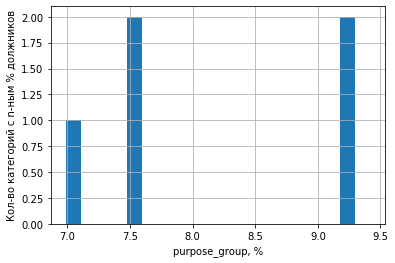

In [20]:
column_mean('purpose_group')

### Вывод

Здесь также процент невернувших в срок от числа взявших в каждой категории колеблется на уровне 7-9%, что не позволяет сказать с уверенностью, что на недвижимость, жильё и свадьбы стоит давать деньги, а вот на авто и образование нет.

### Шаг 4. Общий вывод

In [21]:
def days_employed_abs(days_employed):
    """
    функция для замены отрицательных
    значений на положительные
    """
    days_employed = abs(days_employed)
    return days_employed
solvency_statistics_filtered['days_employed'] = solvency_statistics_filtered['days_employed'].apply(days_employed_abs)
# перезаписываю столбец данными, полученными на выходе функции  days_employed_abs
print(solvency_statistics_filtered['days_employed'])

0          8437
1          4024
2          5623
3          4124
4        340266
          ...  
19346      4529
19347    343937
19348      2113
19349      3112
19350      1984
Name: days_employed, Length: 19351, dtype: int64


Сначала хочется ответить на вопрос откуда могли взяться минус дети и минус дни. Если пользователи вбивали не минус, а тирэ и поле не выдало ошибку 'недопустимый формат ввода', то, очевидно, это недоработка со стороны банка.
Возможно, что минус появился из-за сбоя программы, или те, кто отправил csv файл сами ненарошно добавили артефактов.

Влияние семейного положения и количества детей есть и можно было заметить, что среди вдовцов меньше должников, чем между неженатыми, а также бездетные и у кого 3 ребенка охотнее возвращают, чем те, у кого 1 или 2 ребенка, но разброс совершенно незначительный, и я готов предположить, что при наличии равного количества данных для всех категорий разброс стремился бы к 0.